In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, fft

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

FTYPE = np.float32
ITYPE = np.int32


def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    new_data[:] = data[:]
    new_data *= normalization_arr[1]
    new_data += normalization_arr[0]
    return new_data


def prediction_horizons(**kwargs):
    num_outsteps = kwargs['num_outsteps']
    dir_name_AR_AErnn = kwargs['dir_name_AR_AErnn']
    Autoencoder = kwargs['Autoencoder']
    # all_data = kwargs['all_data']
    data_rnn_input = kwargs['data_rnn_input']
    data_rnn_output = kwargs['data_rnn_output']
    AR_RNN = kwargs['AR_RNN']
    T_sample_input_rnn = kwargs['T_sample_input_rnn']
    T_sample_output_rnn = kwargs['T_sample_output_rnn']
    T_output_fac = kwargs['T_output_fac']
    AR_AERNN = kwargs['AR_AERNN']
    normalization_constant_arr_rnn = kwargs['normalization_constant_arr_rnn']
    normalization_constant_arr_aedata = kwargs['normalization_constant_arr_aedata']
    time_stddev_ogdata = kwargs['time_stddev_ogdata']
    time_mean_ogdata = kwargs['time_mean_ogdata']
    batch_size = kwargs['batch_size']
    num_runs = kwargs.pop('num_runs', 100)
    error_threshold = kwargs.pop('error_threshold', 0.5)
    rnn_data_boundary_idx_arr = kwargs['rnn_data_boundary_idx_arr']
    lyapunov_time_arr = kwargs['lyapunov_time_arr']
    savefig_fname = kwargs['savefig_fname']
    data_to_consider = kwargs['data_to_consider']
    bin_width = kwargs.pop('bin_width', 0.05)
    bin_begin = kwargs.pop('bin_begin', 0.0)
    density = kwargs.pop('hist_pdf_flag', True)
    rnn_wt_extension = kwargs.pop('rnn_wt_extension', 'h5')
    ae_load_file = kwargs.pop('ae_load_file', None)
    ae_wt_file = kwargs.pop('ae_wt_file', None)
    rnn_load_file = kwargs.pop('rnn_load_file', None)
    rnn_wt_file = kwargs.pop('rnn_wt_file', None)
    use_ae_data = kwargs.pop('use_ae_data', True)
    xlabel_kwargs = kwargs.pop('xlabel_kwargs', {'fontsize':15})
    ylabel_kwargs = kwargs.pop('ylabel_kwargs', {'fontsize':15})
    title_kwargs = kwargs.pop('title_kwargs', {'fontsize':18})
    
    if ae_load_file == None:
        ae_load_file = dir_name_AR_AErnn+'/final_net/final_net-{}_outsteps_ae_class_dict.txt'.format(num_outsteps)
    if ae_wt_file == None:
        ae_wt_file = dir_name_AR_AErnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)

    if rnn_load_file == None:
        rnn_load_file = dir_name_AR_AErnn+'/final_net/final_net-{}_outsteps_rnn_class_dict.txt'.format(num_outsteps)
    if rnn_wt_file == None:
        rnn_wt_file = dir_name_AR_AErnn+'/final_net/final_net-{}_outsteps_rnn_weights.'.format(num_outsteps)+rnn_wt_extension
    
    if use_ae_data == True:
        ae_net = Autoencoder(data_rnn_input.shape[2], load_file=ae_load_file)
        ae_net.load_weights_from_file(ae_wt_file)
    else:
        ae_net = None
        normalization_constant_arr_aedata = normalization_constant_arr_rnn
        normalization_constant_arr_rnn = None

    data_in_og = data_rnn_input
    data_out_og = data_rnn_output
    num_runs = np.min([num_runs, data_in_og.shape[0]])
    print('num_runs :', num_runs)

    rnn_net = AR_RNN(
        load_file=rnn_load_file,
        T_input=T_sample_input_rnn,
        T_output=T_sample_output_rnn,
        stddev=0.0,
        batch_size=num_runs,
        # stateful=stateful,
    )
    dt_rnn = rnn_net.dt_rnn
    try:
        dt_rnn = dt_rnn[0]
    except:
        pass
    rnn_dd = rnn_net.data_dim
    try:
        rnn_dd = rnn_dd[0]
    except:
        pass
    print('rnn build input_shape : ', (num_runs, data_rnn_input.shape[1], rnn_dd))
    rnn_net.build(input_shape=(num_runs, data_rnn_input.shape[1], rnn_dd))
    rnn_net.load_weights_from_file(rnn_wt_file)
    
    
    AR_AERNN_net = AR_AERNN(
        ae_net,
        rnn_net,
        normalization_constant_arr_rnn,
        normalization_constant_arr_aedata,
        0.0,
        time_stddev_ogdata,
        time_mean_ogdata,
    )
    # AR_AERNN_net.build(input_shape=(batch_size,)+data_rnn_input.shape[1:])
    
    # data_idx_arr = np.arange(data_in_og.shape[0])
    # np.random.shuffle(data_idx_arr)
    data_idx_arr = np.linspace(0, data_in_og.shape[0]-1, num_runs, dtype=np.int32)

    prediction_horizon_arr = np.empty(shape=num_runs)
    # pod_eigvals_dataout_arr = np.empty(shape=(num_runs, data_out_og.shape[-1]))
    # pod_eigvals_pred_arr = np.empty(shape=(num_runs, data_out_og.shape[-1]))
    # pod_covmat_dataout = np.zeros(shape=(data_out_og.shape[-1], data_out_og.shape[-1]))
    # pod_covmat_pred = np.zeros(shape=(data_out_og.shape[-1], data_out_og.shape[-1]))

    num_outsteps_kk = num_outsteps

    num_outsteps = int(rnn_net.num_outsteps)
    prediction = np.empty(shape=(num_runs,)+tuple(data_out_og.shape[1:]))
    res_tuple = AR_AERNN_net(
        data_in_og[data_idx_arr[0:num_runs]],
        training=False,
        return_res=True
    )
    prediction[:, 0:num_outsteps] = np.array(res_tuple[0])
    iteration_time = time.time()
    for i in range(1, T_output_fac):
        res_tuple = AR_AERNN_net.call_post_warmup(res_tuple)
        prediction[:, i*num_outsteps:(i+1)*num_outsteps] = np.array(res_tuple[0])
    iteration_time = time.time() - iteration_time
    
    prediction = invert_normalization(prediction, normalization_constant_arr_aedata)

    energySpectrum_dataout = 0.0
    energySpectrum_pred = 0.0
    
    data_out_renormd = invert_normalization(data_out_og[data_idx_arr], normalization_constant_arr_aedata)
    
    for i in range(num_runs):
        data_idx = data_idx_arr[i]

        # for j in range(len(rnn_data_boundary_idx_arr)):
        #     if data_idx < rnn_data_boundary_idx_arr[j]:
        #         case_idx = j
        #         break
        case_idx=0
        lyap_time = lyapunov_time_arr[case_idx]

        data_out = data_out_renormd[i]

        ### Error and prediction horizon
        error = (data_out - prediction[i])**2
        error = error / time_stddev_ogdata**2
        error = np.reshape(error, (error.shape[0], -1))
        error = np.mean(error, axis=1)**0.5

        predhor_idx = np.where(error >= error_threshold)[0]
        if predhor_idx.shape[0] == 0:
            predhor_idx = error.shape[0]
        else:
            predhor_idx = np.sort(predhor_idx)[0]

        prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time


    median_idx = int(np.round(0.5*num_runs-1))
    quartile_1_idx = int(np.round(0.25*num_runs-1))
    quartile_3_idx = int(np.round(0.75*num_runs-1))

    idx_sort = np.argsort(prediction_horizon_arr)

    median = prediction_horizon_arr[idx_sort[median_idx]]
    quartile_1 = prediction_horizon_arr[idx_sort[quartile_1_idx]]
    quartile_3 = prediction_horizon_arr[idx_sort[quartile_3_idx]]
    IQR = quartile_3 - quartile_1

    prediction_horizon = np.mean(prediction_horizon_arr)
    stddev_ph = np.std(prediction_horizon_arr)

    ph_mean = np.mean(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    
    s = 'error_threshold = {}, num_runs : {}\n'.format(error_threshold, num_runs)
    s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
    s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
    s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
    s += '1st quartile : {}, 3rd quartile : {}\n\n'.format(quartile_1, quartile_3)
    s += 'total compute time : {:.1f} s., num_iterations : {:.0f}\n'.format(iteration_time, num_outsteps*(T_output_fac-1))
    s += 'total chaos time : {:.1f}'.format(num_outsteps*(T_output_fac-1)*dt_rnn)

    print('\n'+s)
    
    if savefig_fname != None:
        npsavedata_fname = '/longterm-prediction_horizons-'+data_to_consider+'data--{}outsteps'.format(num_outsteps_kk)
        np.savez(
            dir_name_AR_AErnn+npsavedata_fname,
            prediction_horizon_arr=prediction_horizon_arr,
            error_threshold=error_threshold,
        )

        with open(dir_name_AR_AErnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
            fl.write(s)
        npsavepod_fname = '/longterm-states-'+data_to_consider+'data--{}outsteps'.format(num_outsteps_kk)
        np.savez(
            dir_name_AR_AErnn+npsavepod_fname,
            dataout_arr=data_out_renormd,
            preds_arr=prediction,
        )
    fig, ax = plt.subplots()

    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = max(1, int(np.round(bin_end/bin_width)))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=density)
    ax.axvline(prediction_horizon, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)', **xlabel_kwargs)
    ax.set_ylabel('PDF', **ylabel_kwargs)

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=0.6, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmedian : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            median,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.6,
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top',
        **legend_kwargs
    )

    ax.set_title('nbins = {}'.format(nbins), **title_kwargs)

    if savefig_fname is not None:
        fig.savefig(
            dir_name_AR_AErnn+'/plots/longterm-'+savefig_fname+'--{}outsteps.pdf'.format(num_outsteps_kk),
            dpi=300,
            bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    # fig_eigvals, ax_eigvals = plt.subplots()
    # ax_eigvals.semilogy(pod_eigvals_dataout_arr_mean, linestyle='--', marker='s', linewidth=0.9, markersize=2)
    # ax_eigvals.semilogy(pod_eigvals_pred_arr_mean, linestyle='--', marker='^', linewidth=0.9, markersize=2)
    # ax_eigvals.grid(True, which='both', axis='y')
    # ax_eigvals.grid(True, which='major', axis='x')    
    # ax_eigvals.legend([r'True Data', r'Predicted Data'], **legend_kwargs)
    # ax_eigvals.set_axisbelow(True)
    # ax_eigvals.set_title('Eigenvalues of the covariance matrix', **title_kwargs)
    # if savefig_fname is not None:
    #     fig_eigvals.savefig(
    #         dir_name_AR_AErnn+'/plots/'+savefig_fname+'--eigvals--{}outsteps.pdf'.format(num_outsteps_kk),
    #         dpi=300,
    #         bbox_inches='tight')
    #     fig_eigvals.clear()
    #     plt.close()
    # else:
    #     plt.show()
    print('')
    
    return prediction, prediction_horizon_arr

In [2]:
from numpy import *
def main(
        esn_dir_idx, gpu_to_use, data_to_consider='testing',
        T_sample_input_cd_AR=1, T_sample_output_cd_AR=3, T_output_fac=10,
    ):

    strategy = None

    current_sys = platform.system()
    if current_sys == 'Windows':
        dir_sep = '\\'
    else:
        dir_sep = '/'

    print(os.getcwd())

    from tools.misc_tools import create_data_for_RNN, readAndReturnLossHistories
    from tools.ae_v2 import Autoencoder
    from tools.GRU_AR_v1 import AR_RNN_GRU as AR_RNN
#     from tools.LSTM_AR_v1 import AR_RNN_LSTM as AR_RNN
#     from tools.SimpleRNN_AR_v1 import AR_RNN_SimpleRNN as AR_RNN
    from tools.AEGRU_AR_v1 import AR_AERNN_GRU as AR_AERNN

    gpus = tf.config.list_physical_devices('GPU')
    print(gpus)

    if strategy is None:
        # if gpus:
        #     gpu_to_use = 0
        #     tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
        tf.config.set_visible_devices([], 'GPU') # no gpu used
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

    print(tf.config.list_physical_devices())
    print('')
    print(tf.config.list_logical_devices())
    print('')
    print(tf.__version__)


    ###--- Lorenz System ---###
    ### setting up params (and saving, if applicable)

    ### AR AE-RNN directory
    esn_dir_idx = '{:3d}'.format(esn_dir_idx)
    esn_dir_idx = esn_dir_idx.replace(' ', '0')
    dir_name_AR_AErnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_' + esn_dir_idx

    ### reading AR-RNN parameters
    with open(dir_name_AR_AErnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_AR_AErnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_AErnn_dict['dir_name_rnn']
    idx1 = dir_name_rnn[::-1].find('/')
    idx2 = dir_name_rnn[:-idx1-1][::-1].find('/')
    dir_name_rnn = os.getcwd() + dir_name_rnn[-idx1-idx2-1-1:]

    dir_name_ae = params_AR_AErnn_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    dt_rnn = params_AR_AErnn_dict['dt_rnn']
    # T_sample_input = params_AR_AErnn_dict['T_sample_input']
    T_sample_output = params_AR_AErnn_dict['T_sample_output']
    if type(T_sample_output) != type(np.array([])):
        if type(T_sample_output) != type([]):
            T_sample_output = [T_sample_output]
        T_sample_output = np.array(T_sample_output)
    num_outsteps = np.int32(np.round(T_sample_output/dt_rnn))
    # T_offset = params_AR_AErnn_dict['T_offset']
    return_params_arr = params_AR_AErnn_dict['return_params_arr']
    params = params_AR_AErnn_dict['params']
    try:
        # this is the normalization flag for the data fed into the rnn
        normalize_dataset = params_AR_AErnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        use_ae_data = params_AR_AErnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_rnn_specific_data, set to True.")
        use_ae_data = True

    ### reading RNN normalization constants
    normalization_arr_rnn = None
    # if normalize_dataset == True:
    #     with open(dir_name_AR_AErnn + '/final_net/rnn_normalization.txt') as f:
    #         lines = f.readlines()
    #     normarr_rnn_dict = eval(''.join(lines))
    #     normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

    if os.path.exists(dir_name_AR_AErnn+'/normalization_data.npz'):
        with np.load(dir_name_AR_AErnn+'/normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr_rnn = fl['normalization_arr'][0]

    ### training params
    with open(dir_name_AR_AErnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    ### reading simulation parameters
    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    try:
        ae_data_with_params = params_dict['ae_data_with_params']
    except:
        print("'ae_data_with_params' not present in ae_data, set to 'True'.")
        ae_data_with_params = True

    print('dir_name_AR_AErnn:', dir_name_AR_AErnn)
    print('dir_name_rnn:', dir_name_rnn)
    print('dir_name_ae:', dir_name_ae)
    print('data_dir_idx:', data_dir_idx)

    ### loading data
    dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
        
    with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    params_mat = params_dict['params_mat']
    # init_state = params_dict['init_state']
    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']
    return_params_arr = params_dict['return_params_arr']
    normalize_flag_ogdata = params_dict['normalize_flag']
    print('normalize_flag_ogdata:', normalize_flag_ogdata)
    alldata_withparams_flag = params_dict['alldata_withparams_flag']

    with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
        all_data = fl['all_data'].astype(FTYPE)
        boundary_idx_arr = fl['boundary_idx_arr']
        normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
        initial_t0 = fl['initial_t0']
        init_state_mat = fl['init_state_mat']

        lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

    # set which data to use for plotting histogram
    data_to_consider = 'testing' # could be 'all', 'testing', 'training', 'val'

    lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
    for i in range(lyapunov_spectrum_mat.shape[0]):
        lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
        print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

    # delaing with normalizing the data before feeding into autoencoder
    num_params = params_mat.shape[1]
    og_vars = all_data.shape[1]
    if alldata_withparams_flag == True:
        og_vars -= num_params
    time_stddev_ogdata = np.std(all_data, axis=0)
    time_mean_ogdata = np.mean(all_data, axis=0)

    if use_ae_data == True and ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
    else:
        all_data = all_data[:, 0:og_vars]
        
    normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

    print('all_data.shape : ', all_data.shape)
    print('all_data.dtype : ', all_data.dtype)

    ###--- Create Data ---###
    # T_sample_input_cd_AR = 1
    # T_sample_output_cd_AR = 3
    mean_lyap = np.mean(lyapunov_time_arr)
    T_sample_input_cd = T_sample_input_cd_AR*mean_lyap#50.1*dt_rnn
    T_sample_output_cd = T_sample_output_cd_AR*mean_lyap
    
    num_outsteps_og = int((T_sample_output_cd+0.5*dt_rnn)//dt_rnn)
    num_outsteps_total = T_output_fac*num_outsteps_og
    T_sample_output_total = num_outsteps_total*dt_rnn
    T_sample_output_total_AR = T_sample_output_total/mean_lyap
    
    T_offset_cd = T_sample_input_cd

    skip_intermediate_cd = 8*T_sample_input_cd_AR/(T_sample_input_cd_AR+T_sample_output_total_AR)


    all_data = np.reshape(all_data, (all_data.shape[0], -1))
    rnn_res_dict = create_data_for_RNN(
        all_data,
        dt_rnn,
        T_sample_input_cd,
        T_sample_output_total,
        T_offset_cd,
        None,
        boundary_idx_arr,
        delta_t,
        params=params,
        return_numsamples=True,
        normalize_dataset=normalizeforae_flag,
        stddev_multiplier=3.0,
        skip_intermediate=skip_intermediate_cd,
        return_OrgDataIdxArr=False,
        normalization_arr_external=normalization_constant_arr_aedata.reshape(2, -1),
        normalization_type='stddev')

    data_rnn_input = rnn_res_dict['data_rnn_input']
    data_rnn_output = rnn_res_dict['data_rnn_output']
    org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
    org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
    num_samples = rnn_res_dict['num_samples']
    normalization_arr = rnn_res_dict['normalization_arr']
    rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

    # temp = np.divide(all_data-normalization_arr[0], normalization_arr[1])
    time_stddev = time_stddev_ogdata / normalization_arr[1]
    # timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
    del(org_data_idx_arr_input)
    del(org_data_idx_arr_output)
    # del(temp)
    
    del(all_data)

    # data_to_consider = 'all'
    if data_to_consider != 'all':
        cum_samples = rnn_data_boundary_idx_arr[-1]
        num_train = 0
        num_val = 0
        begin_idx = 0
        for i in range(len(boundary_idx_arr)):
            num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
            num_train += int( np.round(train_split*num_samples) )
            num_val += int( np.round(val_split*num_samples) )
            begin_idx = rnn_data_boundary_idx_arr[i]

        # defining shapes
        training_input_shape = [num_train]
        training_input_shape.extend(data_rnn_input.shape[1:])

        training_output_shape = [num_train]
        training_output_shape.extend(data_rnn_output.shape[1:])

        val_input_shape = [num_val]
        val_input_shape.extend(data_rnn_input.shape[1:])

        val_output_shape = [num_train]
        val_output_shape.extend(data_rnn_output.shape[1:])

        testing_input_shape = [cum_samples-num_train-num_val]
        testing_input_shape.extend(data_rnn_input.shape[1:])

        testing_output_shape = [cum_samples-num_train-num_val]
        testing_output_shape.extend(data_rnn_output.shape[1:])

        shape_to_use = eval(data_to_consider+'_input_shape')
        rnn_data_idx = np.empty(shape=shape_to_use[0], dtype=np.int32)
        
        begin_idx = 0
        training_data_rolling_count = 0
        val_data_rolling_count = 0
        testing_data_rolling_count = 0
        for i in range(len(boundary_idx_arr)):
            num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
            num_train = int( np.round(train_split*num_samples) )
            num_val = int( np.round(val_split*num_samples) )
            num_test = num_samples-num_train-num_val+1

            if data_to_consider == 'training':
                rnn_data_idx[training_data_rolling_count:training_data_rolling_count+num_train] = np.arange(begin_idx, begin_idx+num_train)
            elif data_to_consider == 'val':
                rnn_data_idx[val_data_rolling_count:val_data_rolling_count+num_val] = np.arange(begin_idx+num_train, begin_idx+num_train+num_val)
            elif data_to_consider == 'testing':
                rnn_data_idx[testing_data_rolling_count:testing_data_rolling_count+num_test] = np.arange(begin_idx+num_train+num_val, rnn_data_boundary_idx_arr[i])

            training_data_rolling_count += num_train
            val_data_rolling_count += num_val
            testing_data_rolling_count += num_test

            begin_idx = rnn_data_boundary_idx_arr[i]

        # shuffling
        np.random.shuffle(rnn_data_idx)
        data_rnn_input = data_rnn_input[rnn_data_idx]
        data_rnn_output = data_rnn_output[rnn_data_idx]
        del(rnn_data_idx)

    # data_rnn_input = np.reshape(
    #     data_rnn_input,
    #     (data_rnn_input.shape[0], data_rnn_input.shape[1]) + tuple(all_data_shape_og)
    # )
    # data_rnn_output = np.reshape(
    #     data_rnn_output,
    #     (data_rnn_output.shape[0], data_rnn_output.shape[1]) + tuple(all_data_shape_og)
    # )
    print(' data_rnn_input.shape :', data_rnn_input.shape)
    print('data_rnn_output.shape :', data_rnn_output.shape)

    ###--- Prediction Horizon ---###

    num_runs = 50
    num_runs = min(num_runs, data_rnn_input.shape[0])

    # dx = np.linspace(0, 2*np.pi, all_data_shape_og[-1]+1)[0:-1]
    # dx = np.mean(dx[1:]-dx[0:-1])

    # dy = np.linspace(0, 2*np.pi, all_data_shape_og[-2]+1)[0:-1]
    # dy = np.mean(dy[1:]-dy[0:-1])
    
    # num_outsteps = [0]
    return_lst = [
        [
            dir_name_AR_AErnn, data_rnn_input, data_rnn_output,
            normalization_constant_arr_aedata, time_stddev_ogdata,
            lyapunov_time_arr, dt_rnn, num_runs, num_outsteps, time_mean_ogdata,
        ]
    ]
    total_time = 0
    l_tot = num_outsteps.shape[0]+1
    for kk in range(l_tot):
        # try:
        iter_time = time.time()
        total_s_len = 80

        if kk == 0:
            num_outsteps_kk = 'ZERO'
            load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
            wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'

            load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
            wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
        else:
            num_outsteps_kk = num_outsteps[kk-1]
            load_file_rnn = None
            wt_file_rnn = None

            load_file_ae = None
            wt_file_ae = None   

        sep_lr_s = ' num_outsteps : {} '.format(num_outsteps_kk)

        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
        print('\n\n' + '*'*len(sep_lr_s))
        print('' + sep_lr_s+'')
        print('*'*len(sep_lr_s) + '\n\n')

        preds = prediction_horizons(
            num_outsteps=num_outsteps_kk,
            dir_name_AR_AErnn=dir_name_AR_AErnn,
            Autoencoder=Autoencoder,
            data_rnn_input=data_rnn_input,
            data_rnn_output=data_rnn_output,
            AR_RNN=AR_RNN,
            T_sample_input_rnn=T_sample_input_cd,
            T_sample_output_rnn=T_sample_output_cd,
            T_output_fac=T_output_fac,
            AR_AERNN=AR_AERNN,
            normalization_constant_arr_rnn=normalization_arr_rnn,
            normalization_constant_arr_aedata=normalization_constant_arr_aedata,
            time_stddev_ogdata=time_stddev_ogdata,
            time_mean_ogdata=time_mean_ogdata,
            batch_size=num_runs,
            num_runs=num_runs,
            error_threshold=0.5,
            rnn_data_boundary_idx_arr=rnn_data_boundary_idx_arr,
            lyapunov_time_arr=lyapunov_time_arr,
            savefig_fname='NEW--pre-ARtraining'+'_'+data_to_consider+'data--combinedAERNN',
            data_to_consider=data_to_consider,
            bin_width=0.05,
            bin_begin=0.0,
            rnn_wt_extension='h5', # 'h5' for tf saved rnns, 'hdf5' for my ESNs
            rnn_load_file=load_file_rnn,
            rnn_wt_file=wt_file_rnn,
            ae_load_file=load_file_ae,
            ae_wt_file=wt_file_ae,
            use_ae_data=use_ae_data,
        )

        return_lst.append(list(preds))
#         except:
#             print('error')
#             pass
        
        iter_time = time.time() - iter_time
        total_time += iter_time
        avg_time = total_time / (kk+1)
        eta = avg_time*(l_tot-1 -kk)
        print("total_time : {:02d}h {:02d}m {:02d}s ; avg_time : {:02d}h {:02d}m {:02d}s ; ETA : {:02d}h {:02d}m {:02d}s".format(
            int(total_time//3600),
            int((total_time/60)%60),
            int(total_time%60),
            int(avg_time//3600),
            int((avg_time/60)%60),
            int(avg_time%60),
            int(eta//3600),
            int((eta/60)%60),
            int(eta%60),
        ))
    
    
    # return_lst[0][1] = invert_normalization(return_lst[0][1], normalization_constant_arr_aedata)
    # return_lst[0][2] = invert_normalization(return_lst[0][1], normalization_constant_arr_aedata)

    return return_lst
        

# if __name__ == '__main__':
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('gpu_to_use', type=int)
#     parser.add_argument('esn_dir_idx', type=int)
    
#     args = parser.parse_args()
    
#     print('gpu_to_use : {}, esn_dir_idx : {}'.format(args.gpu_to_use, args.esn_dir_idx))
    
#     main(args.esn_dir_idx, args.gpu_to_use)

In [3]:
xlabel_kwargs={"fontsize":15}
ylabel_kwargs={"fontsize":15}
title_kwargs={"fontsize":17}
legend_kwargs={"fontsize":12}

In [4]:
main_tuple = main(2, 0, T_sample_output_cd_AR=5, T_output_fac=10)
main_tuple = list(main_tuple)

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

2.8.1
dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_002
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_rnn/rnn_002
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


2023-08-12 18:41:53.851914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-12 18:41:53.901322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-12 18:41:53.901585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-12 18:41:53.902404: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s
all_data.shape :  (4200001, 3)
all_data.dtype :  float32
 data_rnn_input.shape : (475, 11, 3)
data_rnn_output.shape : (475, 550, 3)


********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : ZERO <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


num_runs : 50
rnn build input_shape :  (50, 11, 2)

error_threshold = 0.5, num_runs : 50
prediction_horizon : 1.5688492585875438, median : 1.5398635909923928
ph_min : 0.3623208449393865, ph_max : 3.2608876044544783
stddev : 0.6205742755111436, IQR : 0.8152219011136195
1st quartile : 1.0869625348181597, 3rd quartile : 1.9021844359317792

total compute time : 5.9 s., num_iterations : 495
total chaos time : 49.5

total_time : 00h 00m 16s ; avg_time : 00h 00m 16s ; ETA : 00h 01m 06s


*************************************************

In [5]:
len(main_tuple), len(main_tuple[0])

(6, 10)

In [6]:
dir_name_rnn = main_tuple[0][0]
data_rnn_input = main_tuple[0][1]
data_rnn_output = main_tuple[0][2]
normalization_constant_arr_aedata = main_tuple[0][3]
time_stddev_ogdata = main_tuple[0][4]
# num_outsteps = main_tuple[0][5]
lyapunov_time_arr = main_tuple[0][5]
dt_rnn = main_tuple[0][6]
num_runs = main_tuple[0][7]
num_outsteps = main_tuple[0][8]
# dx = main_tuple[0][9]
# dy = main_tuple[0][10]
# Re = main_tuple[0][11]
time_mean_ogdata = main_tuple[0][9]

data_rnn_input = invert_normalization(data_rnn_input, normalization_constant_arr_aedata)
data_rnn_output = invert_normalization(data_rnn_output, normalization_constant_arr_aedata)

lyap_time = np.mean(lyapunov_time_arr)
data_idx_arr = np.linspace(0, data_rnn_input.shape[0]-1, main_tuple[1][0].shape[0], dtype=np.int32)
AR_testing_data_rnn_input = data_rnn_input[data_idx_arr]
AR_testing_data_rnn_output = data_rnn_output[data_idx_arr]

im_cmap = 'bwr'
er_cmap = 'viridis'
aspect = 0.25
error_threshold = 0.5
vmin = -3.8
vmax = 3.8

# for i_mt in range(1, len(main_tuple)):
#     # main_tuple[i_mt][3] = compute_d(data_rnn_output-time_mean_ogdata, dx, dy, 1)
#     # main_tuple[i_mt][4] = compute_d(main_tuple[i_mt][0]-time_mean_ogdata, dx, dy, 1)
#     main_tuple[i_mt][3] = compute_d(data_rnn_output, dx, dy, Re)
#     main_tuple[i_mt][4] = compute_d(main_tuple[i_mt][0], dx, dy, Re)
#     # main_tuple[i_mt][6] = compute_w(data_rnn_output-time_mean_ogdata, dx, dy)
#     # main_tuple[i_mt][7] = compute_w(main_tuple[i_mt][0]-time_mean_ogdata, dx, dy)

#     main_tuple[i_mt][6] = compute_w(data_rnn_output, dx, dy)
#     main_tuple[i_mt][7] = compute_w(main_tuple[i_mt][0], dx, dy)
    
#     # main_tuple[i_mt][3] = np.mean(main_tuple[i_mt][6]**2, axis=(-2,-1))/Re
#     # main_tuple[i_mt][4] = np.mean(main_tuple[i_mt][7]**2, axis=(-2,-1))/Re

In [7]:
d_idx = np.random.randint(low=0, high=data_idx_arr.shape[0])
# d_idx = 66, 56, 85, 50
d_idx = 28

d_idx : 28
prediction_horizon : 2.083
2.0833448584014724


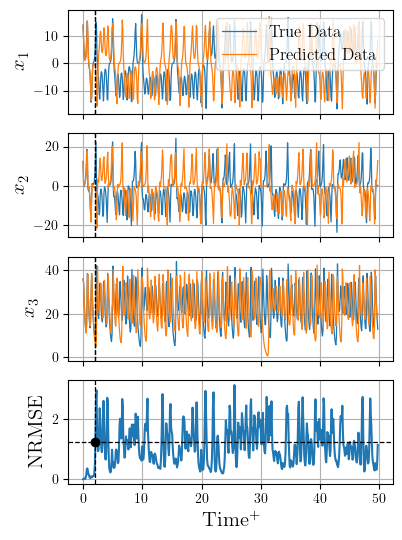

d_idx : 28
prediction_horizon : 1.993
1.9927646471666258


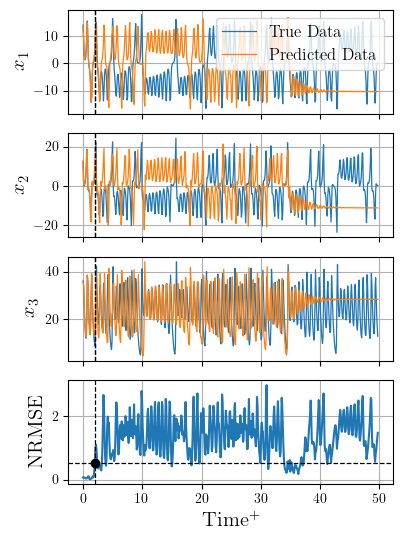

d_idx : 28
prediction_horizon : 1.993
1.9927646471666258


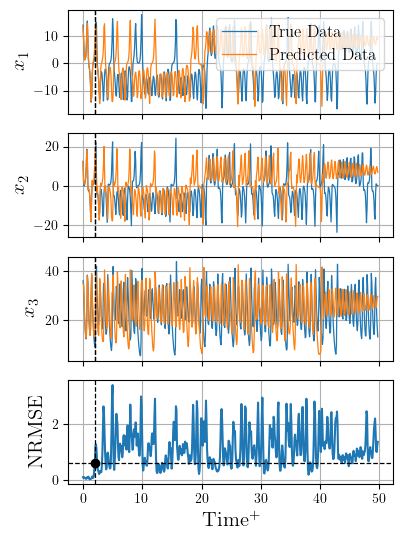

d_idx : 28
prediction_horizon : 2.083
2.0833448584014724


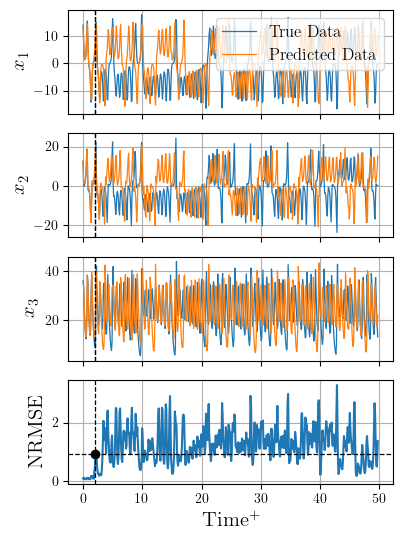

d_idx : 28
prediction_horizon : 2.083
2.0833448584014724


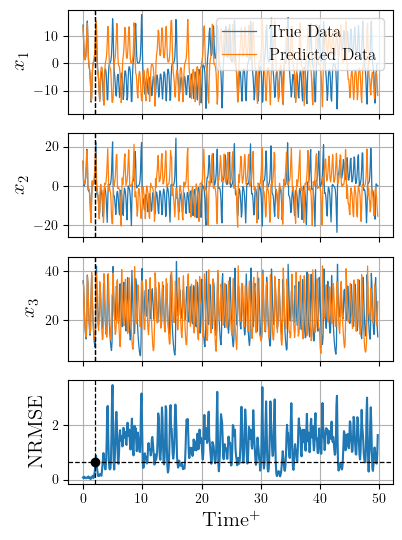

In [8]:
for i_mt in range(1, len(main_tuple)):
    prediction_tuple = main_tuple[i_mt]
    # d_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
    # d_idx = 7 # 1, 7, 11, 86, 99
    print('d_idx : {}'.format(d_idx))

    prediction = prediction_tuple[0][d_idx]
    pred_hor = prediction_tuple[1][d_idx]

    pred_hor_tidx = min(int( np.round(pred_hor*lyap_time/dt_rnn) ), prediction.shape[0]-1)
    print('prediction_horizon : {:.3f}'.format(pred_hor))

    n = 1
    num_latent_states = prediction.shape[-1]
    N = prediction.shape[-2]#num_output_timesteps

    num_cols = 1
    num_rows = n*num_latent_states+1

    ax_ylabels = [r'$x_{'+str(i+1)+'}$' for i in range(num_latent_states)]

    fig, ax = plt.subplots(
        num_latent_states+1, 1,
        sharex=True,
        figsize=np.array([7.5*num_cols, 2.5*num_rows])*0.55)
#     if len(ax.shape) == 1:
#         ax = [ax]
    
#     num_sample_input_AR = prediction.shape[0]
    num_sample_input_AR = AR_testing_data_rnn_input.shape[-2]

    t_plot = np.arange(0, prediction.shape[0])*dt_rnn/lyap_time

    for i in range(3):
        label1 = '__nolegend__'
        label2 = label1
        if i == 0:
            label1 = 'True Data'
            label2 = 'Predicted Data'
        ax[i].plot(t_plot, AR_testing_data_rnn_output[d_idx, :, i], label=label1, linewidth=0.9)#'True Data')
        ax[i].plot(t_plot, prediction[:, i], label=label2, linewidth=0.9)#'Predicted Data')
        # if i == 2:
        #     ax[0, i].set_xlabel(r'Time$^+$', **xlabel_kwargs)
        ax[i].set_ylabel(r'$x_'+str(i+1)+r'$', **ylabel_kwargs)
        ax[i].grid(True)
        
        ax[i].axvline(t_plot[pred_hor_tidx], color='k', linestyle='--', linewidth=0.9)
        # ax[0, i].set_xlim(0, 3)
#         ax[0, i].set_ylim(0, None)
    
    max_rows = 10
    max_rows = float(max_rows)
    # ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
    ncols = int(np.ceil(1 / max_rows))
    ax[0].legend(
        loc=1,
        ncol=ncols,
        **legend_kwargs,
    )

    ### error computation
    error = (AR_testing_data_rnn_output[d_idx] - prediction)**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev_ogdata**2), axis=1)**0.5

    # print(norm_sq_time_average(data_out)**0.5)

    # fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
    ax2 = ax[-1]
    ax2.plot(t_plot, error)
    ax2.grid(True)
    ax2.set_axisbelow(True)
    ax2.set_xlabel('Time$^+$', **xlabel_kwargs)
    ax2.set_ylabel('NRMSE', **ylabel_kwargs)

    error_threshold = 0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if len(predhor_idx.shape) == 0 or predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]-1
    else:
        predhor_idx = np.sort(predhor_idx)[0]
    ax2.plot(t_plot[predhor_idx], error[predhor_idx], 'o', color='k')
    ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
    # ax2.plot(input_time[predhor_idx], error_threshold, 'o', color='k')
    # ax2.axhline(error_threshold, linewidth=0.9, linestyle='--', color='k')

    for i in range(len(ax)):
        ax[i].axvline(t_plot[predhor_idx], linewidth=0.9, linestyle='--', color='k')
    # ax2.set_ylim([0, 2])

    prediction_horizon = predhor_idx*dt_rnn/lyap_time
    print(prediction_horizon)

    plt.tight_layout()

    plot_idx = '{:04d}'.format(num_outsteps[i_mt-2]) if i_mt >= 2 else 'ZERO'

    plt.savefig(
        dir_name_rnn+'/plots/longterm--time_prediction--{}outsteps.pdf'.format(plot_idx),
        dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


#     np.savez(
#         dir_name_rnn+'/plots/longterm--time_prediction--{}outsteps'.format(plot_idx),
#         prediction = prediction_tuple[0][d_idx],
#         ke_dataout_arr = prediction_tuple[1][d_idx],
#         ke_preds_arr = prediction_tuple[2][d_idx],
#         d_dataout_arr = prediction_tuple[3][d_idx],
#         d_preds_arr = prediction_tuple[4][d_idx],
#         pred_hor = prediction_tuple[5][d_idx],
#         w_dataout_arr = prediction_tuple[6][d_idx],
#         w_preds_arr = prediction_tuple[7][d_idx],
#         normalization_constant_arr_aedata=normalization_constant_arr_aedata,
#         dt_rnn=dt_rnn,
#         lyapunov_time_arr=lyapunov_time_arr,
#         num_outsteps=[plot_idx],
#         time_stddev_ogdata=time_stddev_ogdata,
#         d_idx = [d_idx],
#     )

In [9]:
# def window_avg(data, window):
#     new_data = np.zeros_like(data)
#     # new_data[:] = data
#     l_idx = int((window-1)*0.5)
#     r_idx = window-1-l_idx
#     new_data[0:l_idx] = data[0:l_idx]
#     new_data[-r_idx:] = data[-r_idx:]
#     for i in range(l_idx, data.shape[0]-r_idx):
#         for j in range(i-l_idx, i+r_idx+1):
#             new_data[i] += data[j]
#         new_data[i] /= window
#     return new_data

In [10]:
# def compute_W1(P, Q):
#     p_dist = P[0]
#     p_bins = P[1]
#     q_dist = Q[0]
#     q_bins = Q[1]

#     intersect = np.intersect1d(p_bins, q_bins)
    
#     p_lidx = np.where(p_bins==intersect[0])[0][0]
#     p_ridx = np.where(p_bins==intersect[-1])[0][0]
#     q_lidx = np.where(q_bins==intersect[0])[0][0]
#     q_ridx = np.where(q_bins==intersect[-1])[0][0]
    
#     W1 = np.sum(np.abs(p_dist[p_lidx:p_ridx] - q_dist[q_lidx:q_ridx]))
#     if p_lidx > 0:
#         W1 += np.sum(np.abs(p_dist[0:p_lidx]))
#     if p_ridx < p_bins.shape[0]-1:
#         W1 += np.sum(np.abs(p_dist[p_ridx:]))
#     if q_lidx > 0:
#         W1 += np.sum(np.abs(q_dist[0:q_lidx]))
#     if q_ridx < q_bins.shape[0]-1:
#         W1 += np.sum(np.abs(q_dist[q_ridx:]))
        
#     union = np.union1d(p_bins, q_bins)
#     W1 /= union.shape[0]-1

#     return W1

In [11]:
# def compute_KS(P, Q):
#     p_dist = P[0]
#     p_bins = P[1]
#     q_dist = Q[0]
#     q_bins = Q[1]

#     # intersect = np.intersect1d(p_bins, q_bins)
#     union = np.union1d(p_bins, q_bins)
    
#     p_lidx = np.where(union==p_bins[0])[0][0]
#     p_ridx = np.where(union==p_bins[-1])[0][0]
#     q_lidx = np.where(union==q_bins[0])[0][0]
#     q_ridx = np.where(union==q_bins[-1])[0][0]
    
#     p_dist = np.cumsum(p_dist) # PDF --> CDF
#     q_dist = np.cumsum(q_dist) # PDF --> CDF
    
#     # print(p_dist)
#     # print(q_dist)
    
#     p_dist_new = np.zeros(shape=union.shape[0]-1)
#     q_dist_new = np.zeros(shape=union.shape[0]-1)
    
#     p_dist_new[p_lidx:p_ridx] = p_dist[:]
#     p_dist_new[p_ridx:] = 1.0
#     q_dist_new[q_lidx:q_ridx] = q_dist[:]
#     q_dist_new[q_ridx:] = 1.0
    
#     KS = np.max(np.abs(p_dist_new - q_dist_new))

#     return KS

In [12]:
from scipy.stats import gaussian_kde, wasserstein_distance

In [13]:
width = 0.2
W1_global = []
for i in range(3):
    W1_xi = []
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    dataout_xi = np.reshape(AR_testing_data_rnn_output[:, :, i], (-1,))
    min_ = np.min(dataout_xi)
    max_ = np.max(dataout_xi)
    min_fac = int(min_//width)
    max_fac = -int( (-max_)//width )
    bins = np.arange(min_fac, max_fac+1)*width
    temp_ = np.histogram(dataout_xi, bins=bins, density=True)
    kernel = gaussian_kde(temp_[1], bw_method=0.2)
    
    input_plot = np.linspace(min_, max_, 101)
    p_plot = kernel(input_plot)
    ax.plot(
        input_plot,
        p_plot,
        label='True',
        linewidth=6,
        alpha=0.9,
        color='grey',
    )
    
    for i_mt in range(1, len(main_tuple)):
        prediction_tuple = main_tuple[i_mt]
        preds_xi = np.reshape(prediction_tuple[0][:, :, i], (-1,))
        min_ = np.min(preds_xi)
        max_ = np.max(preds_xi)
        min_fac = int(min_//width)
        max_fac = -int( (-max_)//width )
        bins = np.arange(min_fac, max_fac+1)*width
        plot_idx = int(num_outsteps[i_mt-2]) if i_mt >= 2 else int(0)
        temp_ = np.histogram(
            preds_xi,
            bins=bins,
            density=True,
        )
        kernel = gaussian_kde(temp_[1], bw_method=0.2)

        input_plot = np.linspace(min_, max_, 101)
        p_plot = kernel(input_plot)
        ax.plot(
            input_plot,
            p_plot,
            label='Predicted ({:02d} AR steps)'.format(plot_idx),
            # label='Predicted',
            # linewidth=0.9,
            # linestyle='--',
        )
        W1 = wasserstein_distance(dataout_xi, preds_xi)
        W1_xi.append(W1)
        print(W1)
    
    W1_global.append(W1_xi)

    ax.set_xlabel(r'$x_'+str(i+1)+r'$', **xlabel_kwargs)
    ax.set_ylabel('PDF', **ylabel_kwargs)

    plt.grid(True)
    fig.legend(bbox_to_anchor=[1.5, 0.875])
    
    plt.savefig(dir_name_rnn+'/plots/longterm--x{}_pdf.pdf'.format(i+1), dpi=300, bbox_inches='tight')
    
#     plt.show()
    plt.close()
    
with open(dir_name_rnn+'/plots/longterm--pdf--W1.txt', 'w') as f:
    s = 'num_outsteps_AR : '
    s += ', '.join(['{:2d}'.format(int(num_outsteps[i_mt-2]) if i_mt >= 2 else int(0)) for i_mt in range(1, len(main_tuple))])
    s += '\n'
    for i in range(len(W1_global)):
        s += 'x{} W1 : '.format(i+1) + ', '.join(['{:.4E}'.format(elem) for elem in W1_global[i]])
        s += '\n'
    f.write(s)
    print(s)    

0.46838357357174354
6.704296273926776
0.3941413755773786
0.22905768391222803
0.20898616536635312
0.624827700303825
7.480911179624571
0.4145506567149557
0.2601265394478036
0.3751870097418017
0.7447350713369851
5.538638422028007
0.46034063545806125
0.3193351610710503
0.2784528848517456
num_outsteps_AR :  0,  5, 10, 15, 20
x1 W1 : 4.6838E-01, 6.7043E+00, 3.9414E-01, 2.2906E-01, 2.0899E-01
x2 W1 : 6.2483E-01, 7.4809E+00, 4.1455E-01, 2.6013E-01, 3.7519E-01
x3 W1 : 7.4474E-01, 5.5386E+00, 4.6034E-01, 3.1934E-01, 2.7845E-01



In [14]:
# legend_kwargs = {'fontsize':10}
# window = 5
# ########## KE TKE PDF ##########
# width = 0.005
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# x1_dataout_arr = np.reshape(main_tuple[1][1], (-1,))
# min_ = np.min(ke_dataout_arr)
# max_ = np.max(ke_dataout_arr)
# min_fac = int(min_//width)
# max_fac = -int( (-max_)//width )
# bins = np.arange(min_fac, max_fac+1)*width
# temp_ = np.histogram(ke_dataout_arr, bins=bins, density=True)
# og_sum_ = np.sum(temp_[0])
# og_dist = window_avg(temp_[0], window)
# og_bins = temp_[1]
# ax.plot(
#     0.5*(temp_[1][0:-1]+temp_[1][1:]),
#     og_dist,
#     label='True',
#     linewidth=6,
#     alpha=0.9,
#     color='grey',
# )
# W1_TKE = []
# KS_TKE = []
# for i_mt in range(1, len(main_tuple)):
#     prediction_tuple = main_tuple[i_mt]
#     ke_preds_arr = np.reshape(prediction_tuple[2], (-1,))
#     min_ = np.min(ke_preds_arr)
#     max_ = np.max(ke_preds_arr)
#     min_fac = int(min_//width)
#     max_fac = -int( (-max_)//width )
#     bins = np.arange(min_fac, max_fac+1)*width
#     plot_idx = int(num_outsteps[i_mt-2]) if i_mt >= 2 else int(0)
#     temp_ = np.histogram(
#         ke_preds_arr,
#         bins=bins,
#         density=True,
#     )
#     new_sum_ = np.sum(temp_[0])
#     new_dist = window_avg(temp_[0], window)
#     new_bins = temp_[1]
#     W1_TKE.append(compute_W1([new_dist, new_bins], [og_dist, og_bins]))
#     KS_TKE.append(compute_KS([new_dist/new_sum_, new_bins], [og_dist/og_sum_, og_bins]))
#     ax.plot(
#         0.5*(temp_[1][0:-1]+temp_[1][1:]),
#         new_dist,
#         # label='Predicted ({:02d} AR steps)'.format(plot_idx),
#         label='Predicted',
#         # linewidth=0.9,
#         # linestyle='--',
#     )

# xlimoffset = 0.03
# # ax.set_xlim(bins[0]-xlimoffset, bins[-1]+xlimoffset)
# ax.set_xlim(0.05, 0.75)

# ax.grid(True)
# ax.legend(**legend_kwargs)
# ax.set_xlabel('TKE', **xlabel_kwargs)
# ax.set_ylabel('Probability Density Function', **ylabel_kwargs)
# plt.tight_layout()
# plt.savefig(dir_name_rnn+'/plots/longterm--TKE_pdf.pdf', dpi=300, bbox_inches='tight')
# plt.close()

# print('W1_TKE : ', W1_TKE)
# print('KS_TKE : ', KS_TKE)

# ########## Dissipation PDF ##########
# width = 0.005
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# d_dataout_arr = np.reshape(main_tuple[1][3], (-1,))
# min_ = np.min(d_dataout_arr)
# max_ = np.max(d_dataout_arr)
# min_fac = int(min_//width)
# max_fac = -int( (-max_)//width )
# bins = np.arange(min_fac, max_fac+1)*width
# temp_ = np.histogram(d_dataout_arr, bins=bins, density=True)
# og_sum_ = np.sum(temp_[0])
# og_dist = window_avg(temp_[0], window)
# og_bins = temp_[1]
# ax.plot(
#     0.5*(temp_[1][0:-1]+temp_[1][1:]),
#     og_dist,
#     label='True',
#     linewidth=6,
#     alpha=0.9,
#     color='grey',
# )
# W1_D = []
# KS_D = []
# for i_mt in range(1, len(main_tuple)):
#     prediction_tuple = main_tuple[i_mt]
#     d_preds_arr = np.reshape(prediction_tuple[4], (-1,))
#     min_ = np.min(d_preds_arr)
#     max_ = np.max(d_preds_arr)
#     min_fac = int(min_//width)
#     max_fac = -int( (-max_)//width )
#     bins = np.arange(min_fac, max_fac+1)*width
#     plot_idx = int(num_outsteps[i_mt-2]) if i_mt >= 2 else int(0)
#     temp_ = np.histogram(
#         d_preds_arr,
#         bins=bins,
#         density=True,
#     )
#     new_sum_ = np.sum(temp_[0])
#     new_dist = window_avg(temp_[0], window)
#     new_bins = temp_[1]
#     W1_D.append(compute_W1([new_dist, new_bins], [og_dist, og_bins]))
#     KS_D.append(compute_KS([new_dist/new_sum_, new_bins], [og_dist/og_sum_, og_bins]))
#     ax.plot(
#         0.5*(temp_[1][0:-1]+temp_[1][1:]),
#         new_dist,
#         # label='Predicted ({:02d} AR steps)'.format(plot_idx),
#         label='Predicted',
#         # linewidth=0.9,
#         # linestyle='--',
#     )

# offset = 0.05*0.1
# ax.set_xlim(0.-offset, .3+offset)

# ax.grid(True)
# ax.legend(**legend_kwargs)
# ax.set_xlabel(r'Mean Dissipation Rate ($D$)', **xlabel_kwargs)
# ax.set_ylabel('Probability Density Function', **ylabel_kwargs)
# plt.tight_layout()
# plt.savefig(dir_name_rnn+'/plots/longterm--D_pdf.pdf', dpi=300, bbox_inches='tight')
# plt.close()

# print('W1_D : ', W1_D)
# print('KS_D : ', KS_D)

In [15]:
# ########## KE PDF ##########
# width = 0.005
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ke_dataout_arr = 0.5*np.mean(np.sum(data_rnn_output**2, axis=-3), axis=(-2,-1))
# np.reshape(main_tuple[1][1], (-1,))
# min_ = np.min(ke_dataout_arr)
# max_ = np.max(ke_dataout_arr)
# min_fac = int(min_//width)
# max_fac = -int( (-max_)//width )
# bins = np.arange(min_fac, max_fac+1)*width
# temp_ = np.histogram(ke_dataout_arr, bins=bins, density=True)
# og_sum_ = np.sum(temp_[0])
# og_dist = window_avg(temp_[0], window)
# og_bins = temp_[1]
# ax.plot(
#     0.5*(temp_[1][0:-1]+temp_[1][1:]),
#     og_dist,
#     label='True',
#     linewidth=6,
#     alpha=0.9,
#     color='grey',
# )
# W1_KE = []
# KS_KE = []
# for i_mt in range(1, len(main_tuple)):
#     prediction_tuple = main_tuple[i_mt]
#     data_ = 0.5*np.mean(np.sum(prediction_tuple[0]**2, axis=-3), axis=(-2,-1))
#     ke_preds_arr = np.reshape(data_, (-1,))
#     min_ = np.min(ke_preds_arr)
#     max_ = np.max(ke_preds_arr)
#     min_fac = int(min_//width)
#     max_fac = -int( (-max_)//width )
#     bins = np.arange(min_fac, max_fac+1)*width
#     plot_idx = int(num_outsteps[i_mt-2]) if i_mt >= 2 else int(0)
#     temp_ = np.histogram(
#         ke_preds_arr,
#         bins=bins,
#         density=True,
#     )
#     new_sum_ = np.sum(temp_[0])
#     new_dist = window_avg(temp_[0], window)
#     new_bins = temp_[1]
#     W1_KE.append(compute_W1([new_dist, new_bins], [og_dist, og_bins]))
#     KS_KE.append(compute_KS([new_dist/new_sum_, new_bins], [og_dist/og_sum_, og_bins]))
#     ax.plot(
#         0.5*(temp_[1][0:-1]+temp_[1][1:]),
#         new_dist,
#         # label='Predicted ({:02d} AR steps)'.format(plot_idx),
#         label='Predicted',
#         # linewidth=0.9,
#         # linestyle='--',
#     )
# xlimoffset = 0.03
# # ax.set_xlim(bins[0]-xlimoffset, bins[-1]+xlimoffset)
# ax.set_xlim(0.05, 0.75)
    
# ax.grid(True)
# ax.legend(**legend_kwargs)
# ax.set_xlabel('KE', **xlabel_kwargs)
# ax.set_ylabel('Probability Density Function', **ylabel_kwargs)
# plt.tight_layout()
# plt.savefig(dir_name_rnn+'/plots/longterm--KE_pdf.pdf', dpi=300, bbox_inches='tight')
# plt.close()

# print('W1_KE : ', W1_KE)
# print('KS_KE: ', KS_KE)

In [16]:
write_dict = {
    'W1_TKE':W1_TKE,
    'KS_TKE':KS_TKE,
    'W1_D':W1_D,
    'KS_D':KS_D,
    'W1_KE':W1_KE,
    'KS_KE':KS_KE,
}
with open(dir_name_rnn+'/longterm--distributionmetrics.txt', 'w') as f:
    f.write(str(write_dict))

NameError: name 'W1_TKE' is not defined

In [ ]:
np.savez(
    dir_name_rnn+'/longterm--distributionmetrics',
    **write_dict
)

In [ ]:
#